In [1]:
# 공통
import numpy as np
import os

# 일관된 출력을 위해 유사난수 초기화
np.random.seed(42)

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 그림을 저장할 폴더
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "dim_reduction"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

차원 축소로 얻는 이점
- 훈련 속도
- 일부의 경우 성능이 높아진다.
- 시각화, 통찰을 얻기 위해 사용시 유용

단점
- 성능이 일반적으로 하락한다.
- 작업 파이프라인이 복잡해지고 유지 과ㄴ리가 어려워진다.

## 8.1 차원의 저주

고차원의 데이터셋 = 희박한 상태. 

거리가 매우 멀기 때문에 예측에 많은 extrapolation을 해야 하고 예측이 불안정해진다. = 과대적합 위험이 커진다.

훈련 샘플의 밀도를 높이기 위해 훈련 세트의 크기를 키운다. but 차원 수가 커지면 요구되는 샘플이 기하급수로 증가. 충분한 샘플을 얻을 수 없다.

## 8.2 차원 축소를 위한 접근 방법

투영projection

매니폴드학습 Manifold Learning

### 8.2.1 투영

In [3]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles =  np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

SVD 분해를 사용한 PCA

In [12]:
X_centered = X - X.mean(axis=0)

U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [21]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [32]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

In [39]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)
X2D_using_svd = X2D

numpy.linalg.svd(a, full_matrices=True, compute_uv=True, hermitian=False)[source](https://numpy.org/doc/1.17/reference/generated/numpy.linalg.svd.html?highlight=svd#numpy.linalg.svd)
- Singular Value Decomposition.

- When a is a 2D array, it is factorized as u @ np.diag(s) @ vh = (u * s) @ vh, where u and vh are 2D unitary arrays and s is a 1D array of a’s singular values. When a is higher-dimensional, SVD is applied in stacked mode as explained below.

Returns:	
- u : { (…, M, M), (…, M, K) } array
 - Unitary array(s). The first a.ndim - 2 dimensions have the same size as those of the input a. The size of the last two dimensions depends on the value of full_matrices. Only returned when compute_uv is True.

- s : (…, K) array
  - Vector(s) with the singular values, within each vector sorted in descending order. The first a.ndim - 2 dimensions have the same size as those of the input a.

- vh : { (…, N, N), (…, K, N) } array
  - Unitary array(s). The first a.ndim - 2 dimensions have the same size as those of the input a. The size of the last two dimensions depends on the value of full_matrices. Only returned when compute_uv is True.

- hermitian : bool, optional
  - If True, a is assumed to be Hermitian (symmetric if real-valued), enabling a more efficient method for finding singular values. Defaults to False.

numpy.allclose(a, b, rtol=1e-05, atol=1e-08, equal_nan=False)[source](https://numpy.org/doc/1.17/reference/generated/numpy.allclose.html?highlight=allclose#numpy.allclose)
- Returns True if two arrays are element-wise equal within a tolerance.

- The tolerance values are positive, typically very small numbers. The relative difference (rtol * abs(b)) and the absolute difference atol are added together to compare against the absolute difference between a and b.

- If either array contains one or more NaNs, False is returned. Infs are treated as equal if they are in the same place and of the same sign in both arrays.

사이킷런을 이용한 PCA

In [40]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

/data/data/com.termux/files/usr/lib/python3.8/site-packages/sklearn/externals/joblib/_multiprocessing_helpers.py:28: UserWarning: This platform lacks a functioning sem_open implementation, therefore, the required synchronization primitives needed will not function, see issue 3770..  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


In [41]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [42]:
X2D_using_svd[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

In [43]:
np.allclose(X2D, -X2D_using_svd)

True

In [44]:
X3D_inv = pca.inverse_transform(X2D)

복원된 3D가 원본 3D 포인트와 완전히 일치하지는 않는다.

In [45]:
np.allclose(X3D_inv, X)

False

In [46]:
# 재구성 오차 계산
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

0.010170337792848547

한편, SVD 방식의 역변환은 다음과 같다.

In [47]:
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

사이킷런의 PCA클래스는 자동으로 평균을 복원해 준다. 평균을 빼 주면 동일한 재구성을 얻을 수 있다.

In [49]:
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)

True

PCA 객체의 components_ 속성을 통해 계산된 ㅈ 성분을 참조할 수 있다.

In [50]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

In [51]:
Vt[:2]

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

설명된 분산 비율을 확인한다.

In [52]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

첫번째 차원이 84.2%의 분산을 포함, 두번째 차원이 14.6%의 분산ㅇ르 설명한다.

3D -> 2D로 투영되면서 부ㄴ산의 1.1%를 잃엇다.

In [53]:
1 - pca.explained_variance_ratio_.sum()

0.011195535570688975

SVD 방식을 사용했을 ㄸㅐ 설명된 분산의 비율을 계산하려면 다음을 실행한다.

In [55]:
np.square(s) / np.square(s).sum()

array([0.84248607, 0.14631839, 0.01119554])

In [56]:
s

array([6.77645005, 2.82403671, 0.78116597])

그래프로 글ㅕ보자.

3D 화살표를 그래기 위한 유틸리티 클래스입니다(http://stackoverflow.com/questions/11140163 에서 복사했습니다)

In [58]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys,zs
        
    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]), (xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

x와 y의 함수로 평면을 표현한다

In [60]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

(-1.0, 1.0)

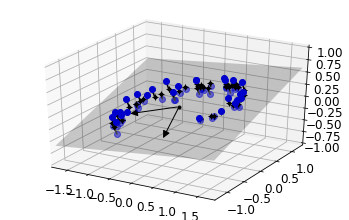

In [91]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 3.8))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)
ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],
                      [0, C[0, 1]],
                      [0, C[0, 2]],
                      mutation_scale=15,
                      lw=1,
                      arrowstyle="-|>",
                      color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],
                      [0, C[1, 1]],
                      [0, C[1, 2]],
                      mutation_scale=15,
                      lw=1,
                      arrowstyle="-|>",
                      color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]],
                "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]],
                "k-", 
                color="#505050")
        
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")

ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

[-1.5, 1.3, -1.2, 1.2]

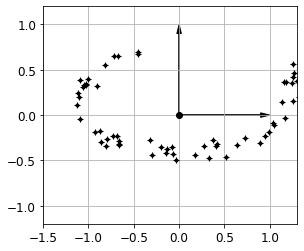

In [113]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1,  head_width=0.05,
         length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0,  head_width=0.05,
         length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.grid(True)
ax.axis([-1.5, 1.3, -1.2, 1.2])

### 8.2.2 매니폴드 학습

In [114]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

/data/data/com.termux/files/usr/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:17: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Mapping, defaultdict


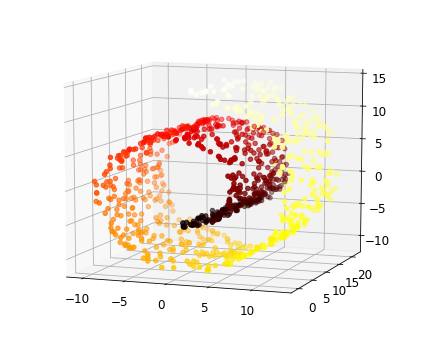

In [119]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("swiss_roll_plot")
plt.show()

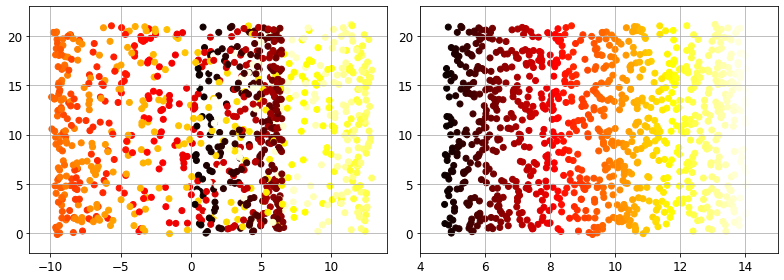

In [127]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.grid(True)

save_fig("squished_swiss_roll_plot")
plt.show()

In [128]:
from matplotlib import gridspec

axes = [-11.5, 14, -2, 23, -12, 15]

x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

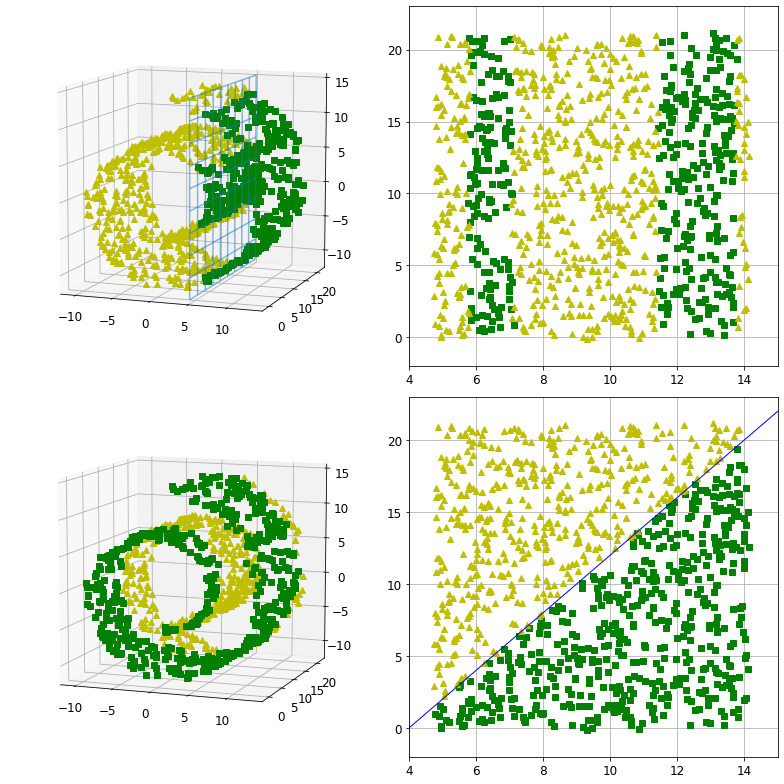

In [150]:
fig = plt.figure(figsize=(11, 11))
ax = plt.subplot(221, projection='3d')
positive_class = X[:, 0] > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
save_fig("manifold_decision_boundary_plot1")

ax = plt.subplot(222)
plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.axis([4, 15, axes[2], axes[3]])
plt.grid(True)
save_fig("manifold_decision_boundary_plot2")

ax = plt.subplot(223, projection="3d")
positive_class = 2 * (t[:] - 4) > X[:, 1]
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
save_fig("manifold_decision_boundary_plot3")

ax = plt.subplot(224)
plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.plot([4, 15], [0, 22], "b-", linewidth=1)
plt.axis([4, 15, axes[2], axes[3]])
plt.grid(True)
save_fig("manifold_decision_boundary_plot4")

plt.show()